### **아마존 뷰티 제품 평점**

 - 2M 개 이상의 고객 리뷰와 평점 정보를 포함한 데이터셋을 가지고 인기 제품 추천과 을 만들어 보자. 앞서 영화 추천과 비슷하게 진행가능하다.

 - 데이터셋에는 총 4가지 정보가 포함되어 있다:

   - 사용자 ID
   - 상품 ID (ASIN이라 부른다)
   - 평점 정보 (1-5)
   - 평점이 주어진 시간

* 앞서 2일차와 4일차 강의 내용을 기반으로 인기도 기반의 추천과 SVD 기반의 추천을 만들어 보자!

--------
--------


### **0. 데이터와 필요 라이브러리 불러오기**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# !wget "https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/ratings_Beauty.csv"
amazon_ratings = pd.read_csv("https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/ratings_Beauty.csv")

#### **0-1. 데이터 확인**


In [2]:
amazon_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


In [3]:
amazon_ratings.shape

(2023070, 4)

In [4]:
amazon_ratings.isna().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

\4가지 정보 중에 하나라도 비어있는 레코드들을 모두 날리고 처음 5개의 레코드를 살펴본다

In [5]:
amazon_ratings = amazon_ratings.dropna()
amazon_ratings.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


몇개의 레코드와 몇개의 컬럼이 있는지 살펴본다

In [6]:
amazon_ratings.shape

(2023070, 4)

In [37]:
amazon_ratings.describe()

,Rating,Timestamp
count,2.023070e+06,2.023070e+06
mean,4.149036e+00,1.360389e+09
std,1.311505e+00,4.611860e+07
min,1.000000e+00,9.087552e+08
25%,4.000000e+00,1.350259e+09
50%,5.000000e+00,1.372810e+09
75%,5.000000e+00,1.391472e+09
max,5.000000e+00,1.406074e+09


In [8]:
rate_count= pd.DataFrame(amazon_ratings.groupby('Rating')['ProductId'].count())
rate_count.rename(columns={'ProductId':'count'}, inplace= True)
rate_count

,count
Rating,
1.0,183784
2.0,113034
3.0,169791
4.0,307740
5.0,1248721


데이터 분포 확인

<Figure size 1170x827 with 0 Axes>

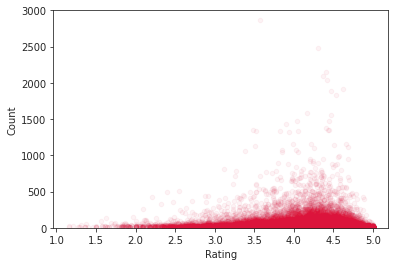

In [45]:
# Rating versus count

product_rating = amazon_ratings.groupby('ProductId')['Rating'].mean()
product_rating_count = amazon_ratings.groupby('ProductId')['Rating'].count()
unreliability = amazon_ratings.groupby('ProductId')['Rating'].std(ddof = -1)
unique_products_list = amazon_ratings.ProductId.unique()

data_model = pd.DataFrame({'Rating': product_rating[unique_products_list],\
                           'Count': product_rating_count[unique_products_list], \
                          'Unreliability': unreliability[unique_products_list]})
data_model= data_model[data_model.Count > 10]

sns.set_style('ticks')
plt.figure(num=None, figsize=(11.7, 8.27), dpi=100, facecolor='w', edgecolor='k')

ax = data_model.plot(kind='scatter', x='Rating', y='Count', color='crimson', alpha=0.05)

plt.ylim([0,3000])
plt.show()

-------
### **1. 메모리 베이스 추천 시스템**


#### **1.1 인기도 기반 추천**

정보가 없는 사용자들에게 가장 쉽게 사용할 수 있는 형태의 추천 방식!
리뷰 수가 가장 큰 상품 10개를 계산해본다.

In [10]:
popular_products = pd.DataFrame(amazon_ratings.groupby('ProductId')['Rating'].count())

most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(10)

,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
B000ZMBSPE,2041
B003BQ6QXK,1918
B004OHQR1Q,1885
B00121UVU0,1838


이 10개를 바 그래프로 그려본다

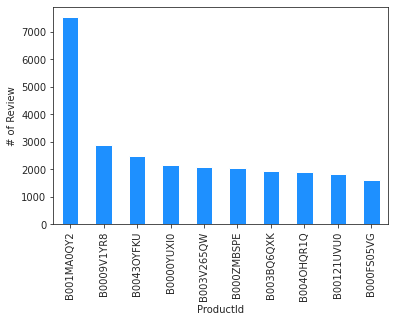

In [50]:
most_popular.head(10).plot(kind = "bar", color= 'dodgerblue', legend= False)
plt.ylabel('# of Review')
plt. show()


리뷰 수가 어느 정도 이상되는 상품을 대상으로 평균 평점이 4이상인 뷰티 상품을 리턴하게 해보자. \\

-----

리뷰 수가 100개 이상인 상품을 대상으로, 평균 평점이 4 이상인 제품들은 

In [53]:
nReview_thr= 100
Rate_thr= 4

def Rec_popular(nRec, nReview_thr, Rate_thr):
  AMZ_cos= pd.DataFrame(amazon_ratings.groupby('ProductId')['Rating'].mean()) # ProductId 에 따른 Rating의 평균값 groupby     
  AMZ_cos.rename(columns={'Rating':'Mean_Rate'}, inplace=True) # column name 'Rating' -> 'Mean_Rate'

  AMZ_cos['Nreview']=popular_products # 제품명에 따른 리뷰 갯수 열 추가 ('Nreview')
  AMZ_cos= AMZ_cos.sort_values('Nreview', ascending=False) # 제품의 리뷰가 많은 순으로 재정렬

  Top_cos= AMZ_cos[(AMZ_cos['Nreview'] >= nReview_thr) & (AMZ_cos['Mean_Rate'] >= Rate_thr)] # 리뷰 100개 이상, 평균 평점 4 이상 추출

  Top_cos.sort_values('Mean_Rate', ascending=False)
  
  recommendU= list(Top_cos.head(nRec).index)

  print("The Top %i cosmetics on Amazon now ! \n"%nRec, recommendU)

Rec_popular(10, nReview_thr, Rate_thr)

The Top 10 cosmetics on Amazon now ! 
 ['B001MA0QY2', 'B0043OYFKU', 'B0000YUXI0', 'B003V265QW', 'B000ZMBSPE', 'B003BQ6QXK', 'B004OHQR1Q', 'B00121UVU0', 'B000FS05VG', 'B000142FVW']


------
### **2. 모델 기반 추천 시스템**

유저의 평점을 예측하여 평점을 준 적 없는 (정보가 없는) 유저에게도 아이템을 추천할 수 있도록 하는것이 목표!



#### **2-1. 모델 만들기 : SVD based!**

##### **i) 데이터 전처리**
효율적인 추천 시스템 구축을 위하여 평점을 10개 미만으로 받은 item은 제외하고 추천한다. 

In [13]:
mProd_ratings = 10
filtered_items = amazon_ratings['ProductId'].value_counts() >= mProd_ratings
filtered_items = filtered_items[filtered_items].index.tolist()


amzRate_filtered = amazon_ratings[amazon_ratings['ProductId'].isin(filtered_items)]
print('The original data frame shape:\t{}'.format(amazon_ratings.shape))
print('The new data frame shape:\t{}'.format(amzRate_filtered.shape))

The original data frame shape:	(2023070, 4)
The new data frame shape:	(1514617, 4)


약 51만 개 정도의 데이터 샘플이 지워졌다.



##### **ii) Surprise SVD**
- Surprise의 동작 progress:  
  1. 객체 생성:  `SVD()`
  2. 학습: `.fit(<train set>)`
  3. 예측: 
    - 전체 test set 예측: `.test(<test set>)` 
    - 단일 sample 예측: `.predict(<User Id>, <Item Id>` 


- 반드시 사용자 아이디, 아이템 아이디, 평점 데이터 순으로 되어있으며, header 없는 데이터셋만 적용 가능! 
  - "surprise" 포멧으로 데이터를 불러올 수 있도록 해야함
  - csv -> surprise 할 경우, 포멧을 지정해주어야 함 (`Reader`이용)
- `surprise.model_selection`의 `GridSearchCV` : 하이퍼 파라미터를 그리드 서치하여 최적 hyper parameter 찾아주고, 교차 검증 해줌.

- Hyper-parameter:
  - `n_factors`: 축소 차원 수 ( ∑ 의 dimension)
  - `n_epochs`: 전체 데이터 셋 훈련 횟수
  - `lr_all`: learning rate


refs)
- https://big-dream-world.tistory.com/70
- https://techblog-history-younghunjo1.tistory.com/117


###### **ii)-1. 필요한 메서드 import**

In [14]:
%pip install surprise
import surprise
from surprise import Dataset, dataset, Reader
from surprise.model_selection import GridSearchCV, cross_validate,train_test_split
from surprise import accuracy

import heapq

from collections import defaultdict
from operator import itemgetter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 3.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633958 sha256=a69ec4ee015d020a6371cc3310ec3421a88523f27b8568ad0c78035d4ebfb766
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


###### **ii)-2. Surprise Dataframe 형식으로 변환**


In [15]:
# """Pandas Dataframe 2 Surprise Dataframe"""

class Pd2Sur(dataset.DatasetAutoFolds):
    def __init__(self, df, reader):
        self.raw_ratings = [(uid, iid, r, None) for (uid, iid, r) in
                            zip(df['UserId'], df['ProductId'], df['Rating'])]
        self.reader=reader


reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines= 1)
data = Pd2Sur(amzRate_filtered, reader) # 평점이 10개 이하인 items를 제외 & 평점기록 있는 샘플들 데이터셋을 불러옴!


###### **ii)-3. 최적의 Hyper-params / Algorithm 탐색**

- 최적 hyperparameter ? `GridSearchCV()`

In [16]:
# #@title
# # """최적값 탐색 (GridSearchCV) & k-fold Validation"""
# param_grid = {                # 탐색할 최적hyper-parameter 사전 지정 
#     'n_epochs': [20,30],
#     'lr_all': [0.005, 0.010],
#     'n_factors' : [50,100]
# }
# gs= GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
# gs.fit(data)

# # RMSE
# print("Best RMSE score attained: ", gs.best_score['rmse'])
# print("Best RMSE params: ", gs.best_params['rmse'])

# # MAE
# print("Best RAE score attained: ", gs.best_score['mae'])
# print("Best RAE params: ", gs.best_params['mae'])

# # Best RMSE score attained:  1.2507946607501712
# # Best RMSE params:  {'n_epochs': 20, 'lr_all': 0.005, 'n_factors': 50}
# # Best RAE score attained:  0.96847657418555
# # Best RAE params:  {'n_epochs': 50, 'lr_all': 0.01, 'n_factors': 50}

# #@title
# svd= gs.best_estimator['rmse']
# trn= data.build_full_trainset() # 모든 데이터 샘플을 train set으로!
# svd.fit(trn)



--> 너무!! 오래걸림ㅠ 

- 최적의 SVD 기반 알고리즘 탐색
  : **SVD, SVDpp, NormalPredictor, BaselineOnly**

In [17]:
# from surprise import SVD, SVDpp, NormalPredictor, BaselineOnly

# algos = []
# # 모든 알고리즘을 literate화 시켜서 반복문을 실행시킨다.
# for algorithm in [SVD(), SVDpp(), NormalPredictor(),BaselineOnly()]:
    
#     # 교차검증
#     results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
#     # 결과 저장과 알고리즘 이름 추가
#     tmp = pd.DataFrame.from_dict(results).mean(axis=0)
#     tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
#     algos.append(tmp)
    
# pd.DataFrame(algos).set_index('Algorithm').sort_values('test_rmse')    
  

# Estimating biases using als...
# Estimating biases using als...
# Estimating biases using als...
# test_rmse	fit_time	test_time
# Algorithm			
# BaselineOnly	1.251366	13.151686	5.769353
# SVD	1.252803	91.789061	9.232320
# SVDpp	1.259822	168.864259	15.021568
# NormalPredictor	1.671706	3.090116	8.251137
# runtime: 2h 20m 18s

-> Baseline 고려한 알고리즘이 가장 성능 

괜찮으므로, **BaselineOnly** 채택!

###### **ii)-4. Train-Test set**


In [18]:
from surprise.model_selection import train_test_split
trn, tst = train_test_split(data, test_size=.3)


###### **ii)-5. BaselineOnly 학습 & 피팅**


In [19]:
from surprise import BaselineOnly

bsl_options = {
    "method": "sgd",
    "n_epochs": 20,
    "learning_rate": 0.005
}
BLO = BaselineOnly(bsl_options=bsl_options)
BLO.fit(trn)

pred=[]
pred= BLO.test(tst)

Estimating biases using sgd...


In [20]:
print("RMSE: ",accuracy.rmse(pred))
print("MAE: ", accuracy.mae(pred))

RMSE: 1.2342
RMSE:  1.2342336960291918
MAE:  0.9625
MAE:  0.9624716892930252


예측값을 다루기 쉽게 pandas DataFrame 형식으로 변환

In [21]:
results_list=[]

for result in pred:
  results_list.append([result.uid, result.iid, result.r_ui, result.est])
  

results= pd.DataFrame(results_list,columns= ['UserId','ProductId','Rating','Pred_bl'])
results.head(10)

,UserId,ProductId,Rating,Pred_bl
0,A2EYVGXW1H3ZFR,B005WWBGPO,5.0,4.296536
1,A1WLDL2OWMTC18,B000SWY02O,5.0,4.380759
2,A2CHH5P055A0KL,B0030HKJ8I,5.0,4.519408
3,A3AERJ7NNSM3OC,B005KO7NK6,5.0,3.933202
4,A29EFNCFEELB6S,B00772AKMM,5.0,4.846733
5,A3CYZDGVELZZ8T,B001JDHR4Y,5.0,4.337216
6,A3K6OJS5JIZ1AW,B0012RYDWG,5.0,4.370013
7,A3LH77PBDFEO3F,B00067YSLO,5.0,4.265435
8,A1BA21XNJIB87I,B00AM8923G,5.0,3.521402
9,A2PDIW4392JBT0,B00BOH1PQQ,5.0,3.633190


Train, Test set 아니었던 값 넣어서 prediction 해보기 

In [22]:
real_mat= results.head(10000).pivot_table(values='Rating', index='UserId', columns='ProductId')
real_mat.head()

ProductId,535795531X,7806397051,9790778872,9790786875,9790789939,9790790961,B00004TUBL,B00004TUBV,B00004U9V2,B000050B6U,...,B00KCTER3U,B00KD73PBQ,B00KGDRCZW,B00KH6F6TM,B00KNIL36E,B00KQBR9FM,B00KQWBJ5W,B00KTLBEEQ,B00KTP8Q1G,B00L5JHZJO
UserId,,,,,,,,,,,,,,,,,,,,,
A0018632VUVKRGSYBEAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A02238611KADHRFBPKAUK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A03197302XWG2A14N14YQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0459829SI5B5WIOZZHX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A059303511MRU8YSIIYJ1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###### **ii)-6 Performance**


In [23]:
BLO.predict("A004511036AHSSV5O4SBY","9788071198")

Prediction(uid='A004511036AHSSV5O4SBY', iid='9788071198', r_ui=None, est=3.9683410311151626, details={'was_impossible': False})

In [24]:
from sklearn import metrics

def scoring(y_true, y_pred):
    r2= round(metrics.r2_score(y_true, y_pred)*100,3)
    
    corr= round(np.corrcoef(y_true, y_pred)[0,1],3)
    mape= round(
        metrics.mean_absolute_percentage_error(y_true, y_pred)*100,3)
    rmse= round(metrics.mean_squared_error(y_true, y_pred, squared=False),3)
    
    df= pd.DataFrame({"R2":r2,
                     "Corr": corr,
                     "RMSE": rmse,
                     "MAPE":mape},
                    index=[0])
    return df

scoring(results.Rating, results.Pred_bl)

,R2,Corr,RMSE,MAPE
0,10.628,0.326,1.234,44.014


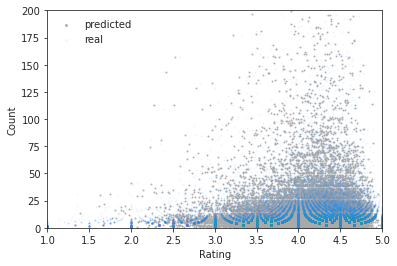

In [54]:
product_rating_predbl = results.groupby('ProductId')['Pred_bl'].mean()
product_rating_count_predbl = results.groupby('ProductId')['Pred_bl'].count()
product_rating_count_predbl= product_rating_count_predbl[product_rating_count_predbl > 0]
unreliability_predbl = results.groupby('ProductId')['Pred_bl'].std(ddof = -1)
unique_products_list_predbl = results.ProductId.unique()

data_model_predbl = pd.DataFrame({'Rating': product_rating_predbl[unique_products_list_predbl],\
                                 'Count': product_rating_count_predbl[unique_products_list_predbl], \
                                 'Unreliability': unreliability_predbl[unique_products_list_predbl]})


product_rating = results.groupby('ProductId')['Rating'].mean()
product_rating_count = results.groupby('ProductId')['Rating'].count()
product_rating_count= product_rating_count[product_rating_count > 0]
unreliability = results.groupby('ProductId')['Rating'].std(ddof = -1)
unique_products_list = results.ProductId.unique()

data_model = pd.DataFrame({'Rating': product_rating[unique_products_list],
                          'Count': product_rating_count[unique_products_list], 
                          'Unreliability': unreliability[unique_products_list]})



plt.figure(figsize=(6,4))

plt.scatter(data_model_predbl.Rating, data_model_predbl.Count, c='darkgrey', s=1, alpha= 0.8)
plt.scatter(data_model.Rating, data_model.Count, c='dodgerblue', s=1, alpha= 0.05)


plt.xlabel('Rating')
plt.ylabel('Count')
plt.ylim([0,200])
plt.xlim([1,5])
plt.legend(['predicted', 'real'],markerscale=2, frameon= False)

plt.show()


------------
#### **2-2. Comparison with an Open Source Algorithm from kaggle**



https://www.kaggle.com/code/swaroopnath6/recommender-system?scriptVersionId=32138732&cellId=55

<br><br>
<span style="color:grey"> Observation - The root mean square in predictions drastically reduce with the hypothesis we assumed.  
<br><br>


The predictions are also done in a very impressive time - ~2 minutes for ~30000 user ids

<br><br>

Using the rating that is devoid of baseline rating does seem to give better results than the plain simple system. There are a very important deduction from these experimental results -
<br><br>

It is better to predict the overhead rating (by ignoring the baseline rating), and then add the baseline rating.   

This means that hypothesis:  
"People ** usually tend to rate some product at a baseline level (3 here) unless the product experience with the user is very bad**" is a better start off point for a Recommender system.

<br><br>

The second perspective is definitely better in producing results. But how can it be improved? Can there be a third segment in the rating? Yes, definitely!

Intuition - Have you experienced yourself rating drivers of a particular application (Uber, in my case) more generously/harshly day by day?  
This is the third aspect in rating - a general user experience with the application.   
In the context of movies, you can imagine this as you being a harsher critic day by day. This kind of interaction (user - service) can be modelled using the timestamp provided. We will look at such interactions closely in later part of this notebook.

In general -  

𝑅𝑎𝑡𝑖𝑛𝑔=𝐵𝑎𝑠𝑒𝑙𝑖𝑛𝑒𝑅𝑎𝑡𝑖𝑛𝑔 +  𝑈𝑠𝑒𝑟𝑆𝑒𝑟𝑣𝑖𝑐𝑒𝐼𝑛𝑡𝑒𝑟𝑎𝑐𝑡𝑖𝑜𝑛𝑅𝑎𝑡𝑖𝑛𝑔 +  𝑈𝑠𝑒𝑟𝑃𝑟𝑜𝑑𝑢𝑐𝑡𝐼𝑛𝑡𝑒𝑟𝑎𝑐𝑡𝑖𝑜𝑛𝑅𝑎𝑡𝑖𝑛𝑔 

</span>

In [26]:
from tqdm import tqdm
class ModelRecommender:
    def __init__(self, strategy = 'SVD', latent_factors = 5, num_epochs = 10, reg_param = 0.01):
        self.strategy = strategy
        self.latent_factors = latent_factors = 5
        self.num_epochs = 10
        self.reg_param = reg_param
        self.learning_rate = 0.0005
        
    def fit(self, matrix):
        m, n = matrix.shape
        self.P = pd.DataFrame(np.random.rand(m, self.latent_factors), index = matrix.index) # Users
        self.Q = pd.DataFrame(np.random.rand(n, self.latent_factors), index = matrix.columns) # Products
        
        users = list(matrix.index)
        products = list(matrix.columns)

        for epoch in tqdm(range(self.num_epochs), desc = 'Epoch'):
            for user, product in zip(users, products):
                error = matrix.loc[user, product] - self.predictions(self.P.loc[user].values, self.Q.loc[product].values)
                self.P.loc[user] += self.learning_rate * (error * self.Q.loc[product].values - self.reg_param * self.P.loc[user].values)
                self.Q.loc[product] += self.learning_rate * (error * self.P.loc[user].values - self.reg_param * self.Q.loc[product].values)
                
    def predictions(self, P, Q):
        return np.dot(P, Q.T)
    
    def predict(self, X_test):
        y_pred = pd.Series(index = X_test.index)
        
        for index, row in X_test.iterrows():
            user_id = row['UserId']
            product_id = row['ProductId']
            if user_id not in self.P.index:
                y_pred.loc[index] = 0
                continue
            if product_id not in self.Q.index:
                y_pred.loc[index] = 0
                continue
            pred = self.predictions(self.P.loc[user_id].values, self.Q.loc[product_id].values)
            y_pred.loc[index] = pred
        
        return y_pred.values
    
    def recommend(self, user_id, num_recommendations = 10):
        recommendations = pd.DataFrame(columns = ['ProductId', 'Recommendability'])
        
        for product_id in self.Q.index:
            recommendability = self.predictions(self.P.loc[user_id].values, self.Q.loc[product_id].values)
            recommendations = recommendations.append({'ProductId': product_id, 'Recommendability': recommendability}, ignore_index = True)
            
        recommendations.sort_values(by = 'Recommendability', ascending = False, inplace = True)
        
        max_recommendations = min(num_recommendations, self.Q.shape[0])
        return recommendations #.iloc[:max_recommendations, 0]
        

In [27]:
amazon_ratings1 = amzRate_filtered.head(10000)
ratings_utility_matrix = amazon_ratings1.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_utility_matrix.head()

ProductId,1304351475,1403790965,3227001381,535795531X,5357955948,602260074X,7535842801,7806397051,7899123011,8096399322,...,B000052ZSS,B000052ZTY,B00005302B,B00005302X,B00005303P,B00005304H,B00005304L,B000053056,B000053071,B0000530ED
UserId,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0,0,0,0,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
A00473363TJ8YSZ3YAGG9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03056581JJIOL5FSKJY7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03099101ZRK4K607JVHH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0505229A7NSH3FRXRR4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
recommender= ModelRecommender() # 객체 생성
recommender.fit(ratings_utility_matrix) # SVD fitting (학습)

Epoch: 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


In [29]:
data = amzRate_filtered.iloc[:, :-1] # 학습하기 좋은 형태의 dataframe 생성 =data
data.head()


,UserId,ProductId,Rating
26,A1RXI3A1E99112,1304351475,5.0
27,A26QL1FBQO9C0E,1304351475,5.0
28,A19KEEVZYO1KO6,1304351475,4.0
29,A1F6HRR58TQ2R0,1304351475,5.0
30,AVQP6PO1NK0IJ,1304351475,1.0


In [30]:
from sklearn.model_selection import train_test_split # data train(trn) - test(tst)8:2로 분할 
from sklearn.metrics import mean_squared_error
trn, tst, _, _ = train_test_split(data, np.zeros(data.shape[0]), test_size = 0.2)
tstX = tst.iloc[:, :-1] # test set의 feature (X) 와 예측 타겟 (Y) 나눠줌 
tstY = tst.iloc[:, -1]  


predY = recommender.predict(tstX) # 학습 결과를 기반으로 tst set의 feature 넣어 tstY 예측 (==predY)
rmse = np.sqrt(mean_squared_error(tstY, predY)) # 예측값 predY와 실제 값 tstY rmse 

print('RMSE using normal rating method: {}'.format(rmse))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


RMSE using normal rating method: 4.343167603396641


**!**
사람들은 아무리 물품이 나빠도 중간점수는 주는 경향이 있음.  
원 developer는 그냥 rating median 인 3을 기본값으로 설정하였으나,
여기서는 분포의 -2$\sigma$값인 2를 이용해보겠음. 

In [31]:
recommender_BL = ModelRecommender()
recommender_BL.fit(ratings_utility_matrix)

Epoch: 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


In [32]:
# 일단 원래 코드 
predY_BL = recommender_BL.predict(tstX)
predY_BL += 3
rmse_BL= np.sqrt(mean_squared_error(tstY, predY_BL))

print('RMSE using baseline rating method: {}'.format(rmse_BL))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


RMSE using baseline rating method: 1.7357381189349892


In [33]:
result= tst
result['pred']= predY
result['pred_bl']= predY_BL

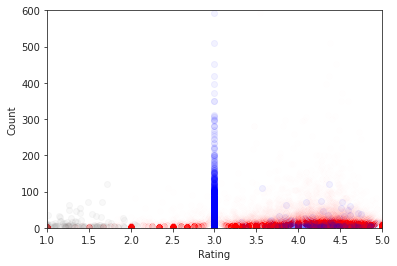

In [34]:
# Rating versus count
product_rating_pred = result.groupby('ProductId')['pred'].mean()
product_rating_count_pred = result.groupby('ProductId')['pred'].count()
unreliability_pred = result.groupby('ProductId')['pred'].std(ddof = -1)
unique_products_list_pred = result.ProductId.unique()

data_model_pred = pd.DataFrame({'Rating': product_rating_pred[unique_products_list_pred],
                               'Count': product_rating_count_pred[unique_products_list_pred], 
                                'Unreliability': unreliability_pred[unique_products_list_pred]})


product_rating_predbl = result.groupby('ProductId')['pred_bl'].mean()
product_rating_count_predbl = result.groupby('ProductId')['pred_bl'].count()
unreliability_predbl = result.groupby('ProductId')['pred_bl'].std(ddof = -1)
unique_products_list_predbl = result.ProductId.unique()

data_model_predbl = pd.DataFrame({'Rating': product_rating_predbl[unique_products_list_predbl],\
                                 'Count': product_rating_count_predbl[unique_products_list_predbl], \
                                 'Unreliability': unreliability_predbl[unique_products_list_predbl]})


product_rating = result.groupby('ProductId')['Rating'].mean()
product_rating_count = result.groupby('ProductId')['Rating'].count()
unreliability = result.groupby('ProductId')['Rating'].std(ddof = -1)
unique_products_list = result.ProductId.unique()

data_model = pd.DataFrame({'Rating': product_rating[unique_products_list],
                          'Count': product_rating_count[unique_products_list], 
                          'Unreliability': unreliability[unique_products_list]})




plt.scatter(data_model.Rating, data_model.Count, c='red', alpha= 0.005)

plt.scatter(data_model_pred.Rating, data_model_pred.Count, c='grey', alpha= 0.05)

plt.scatter(data_model_predbl.Rating, data_model_predbl.Count, c='blue', alpha= 0.05)


plt.xlabel('Rating')
plt.ylabel('Count')
plt.ylim([0,600])
plt.xlim([1,5])
plt.show()

#### **2-3. 추천**

In [57]:
def recommend(user, data, nRecommend):
  
  products= data.ProductId.unique()
  Recommmendable=pd.DataFrame(index= products, columns=['Rate'])

  for it in products:
    pred_rate= BLO.predict(user, it, verbose=False).est
    Recommmendable.loc[it]= pred_rate

  Recommmendable.sort_values(by = 'Rate', ascending = False, inplace = True)
  Recommend4U= list(Recommmendable.index[:nRecommend])

  print( "Top-%i Recommendation for %s ! \n"%(nRecommend,user), Recommend4U)
  


recommend('A004511036AHSSV5O4SBY', amazon_ratings, 15)

Top-15 Recommendation for A004511036AHSSV5O4SBY ! 
 ['B004CNRDBU', 'B002YFN49I', 'B004AQKY2Y', 'B00K7ER6LU', 'B004AI5756', 'B0046ZHQAW', 'B001F0RBRE', 'B00474JA2Y', 'B004SQ69J8', 'B002IULDP6', 'B00GJX58PE', 'B009OWSHQE', 'B005V247N8', 'B0006B65PC', 'B004PBVHZ2']
